## Feed Forward Network Predictions

In [1]:
##create the classes and prepare the data
import os, sys

sys.path.append(os.path.abspath("../data_set_generator"))
sys.path.append(os.path.abspath("../network_training"))
sys.path.append(os.path.abspath("../data_preprocessing"))
sys.path.append(os.path.abspath("../data"))


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
import keras
from keras import optimizers
from data_set_generator.bike_prediction import DataGenerator
from data_set_generator.data_config import BikeDataConfig
from network_training.network_generator import NetworkGenerator
from network_training.callbacks import Callbacks

highest_class = 8
conf = BikeDataConfig(bikes_path = './/../data//bikes.csv', weather_path = './/../data//weather.csv', highest_class = highest_class)
FFN_logs_base_dir='./Modellcheckpoints/FFn/'
os.makedirs(FFN_logs_base_dir, exist_ok=True)
FFN_log_dir=os.path.join(FFN_logs_base_dir, '_FFN.h5')
callbacks = Callbacks(filepath = FFN_log_dir)


batch_size = 256
input_dims = 11
output_dims = highest_class +1 
adam_optimizer = optimizers.Adam(learning_rate = 1e-4, beta_1=1- 1e-4, amsgrad = True)
sdg_optimizer = optimizers.SGD(learning_rate = 1e-2,  momentum = 0.9, nesterov = True)

network_gen = NetworkGenerator(data_generator = conf.d_gen, callbacks = callbacks)

2025-06-23 15:48:16.151664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Create Batch Generators

In [2]:
train_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.train_list_x,
                             y_data = network_gen.data_gen.train_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             random = True)

val_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.vali_list_x,
                             y_data = network_gen.data_gen.vali_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

test_data_generator = network_gen.batch_generator(batch_size = batch_size, 
                             sequence_length = network_gen.history_length, 
                             x_data = network_gen.data_gen.test_list_x,
                             y_data = network_gen.data_gen.test_list_y,
                             min_index = 0,
                             num_x_signals = input_dims,
                             num_y_signals = output_dims,
                             all_data = True)

x_batch, y_batch = next(train_data_generator)
print(x_batch)
print(y_batch)

[[[ 0.77469835  0.54316378  0.         ...  0.          0.59130965
    0.8064446 ]]

 [[ 0.77468936  0.54317987  0.         ...  1.          0.53729961
    0.84339145]]

 [[ 0.77468837  0.54314303  0.         ...  1.         -0.97629601
    0.21643961]]

 ...

 [[ 0.77461529  0.54307175  0.         ...  1.         -0.87672676
    0.48098877]]

 [[ 0.77475748  0.54335612  0.         ...  1.         -0.92387953
    0.38268343]]

 [[ 0.7745871   0.54303512  0.         ...  1.          0.9961947
   -0.08715574]]]
[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


## Define and Create a FFN

In [3]:
model = keras.Sequential([keras.layers.Flatten(input_shape = (network_gen.history_length, x_batch.shape[-1])),
                keras.layers.Dense(4*input_dims+1, activation = 'relu',  kernel_initializer='he_normal'),
                keras.layers.Dense(4*input_dims+1, activation = 'relu',  kernel_initializer='he_normal'),
                keras.layers.Dense(output_dims, activation = 'softmax')]
        )
print(model.summary())

network_gen.register_network(model)
network_gen.model.compile(optimizer = adam_optimizer, loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
results = network_gen.train_network(validation_data = val_data_generator, epochs = 25, train_data = train_data_generator)

/home/flo/python_environments/ml/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,024 (11.81 KB)

 Trainable params: 3,024 (11.81 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/25
1277/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.2126 - loss: 2.1148

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 65s 50ms/step - categorical_accuracy: 0.2130 - loss: 2.1139 - val_categorical_accuracy: 0.3606 - val_loss: 1.6527
Epoch 2/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.3724 - loss: 1.6127

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.3724 - loss: 1.6126 - val_categorical_accuracy: 0.4703 - val_loss: 1.3187
Epoch 3/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.5475 - loss: 1.2829

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - categorical_accuracy: 0.5476 - loss: 1.2827 - val_categorical_accuracy: 0.5401 - val_loss: 1.0558
Epoch 4/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.6587 - loss: 1.0250

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - categorical_accuracy: 0.6587 - loss: 1.0249 - val_categorical_accuracy: 0.6811 - val_loss: 0.8617
Epoch 5/25
1279/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.7769 - loss: 0.8240

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.7770 - loss: 0.8239 - val_categorical_accuracy: 0.8387 - val_loss: 0.6952
Epoch 6/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8597 - loss: 0.6616

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - categorical_accuracy: 0.8597 - loss: 0.6615 - val_categorical_accuracy: 0.8877 - val_loss: 0.5783
Epoch 7/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.8974 - loss: 0.5472

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - categorical_accuracy: 0.8974 - loss: 0.5472 - val_categorical_accuracy: 0.9100 - val_loss: 0.4766
Epoch 8/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9320 - loss: 0.4474

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - categorical_accuracy: 0.9320 - loss: 0.4473 - val_categorical_accuracy: 0.9277 - val_loss: 0.4043
Epoch 9/25
1280/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9468 - loss: 0.3729

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.9469 - loss: 0.3728 - val_categorical_accuracy: 0.9362 - val_loss: 0.3560
Epoch 10/25
1280/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9546 - loss: 0.3218

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - categorical_accuracy: 0.9546 - loss: 0.3217 - val_categorical_accuracy: 0.9441 - val_loss: 0.3206
Epoch 11/25
1282/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9607 - loss: 0.2903

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - categorical_accuracy: 0.9607 - loss: 0.2903 - val_categorical_accuracy: 0.9468 - val_loss: 0.3114
Epoch 12/25
1281/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9639 - loss: 0.2612

1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.9639 - loss: 0.2612 - val_categorical_accuracy: 0.9486 - val_loss: 0.3024
Epoch 13/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.9666 - loss: 0.2430 - val_categorical_accuracy: 0.9478 - val_loss: 0.3045
Epoch 14/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.9664 - loss: 0.2400 - val_categorical_accuracy: 0.9494 - val_loss: 0.3094
Epoch 15/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical_accuracy: 0.9667 - loss: 0.2438 - val_categorical_accuracy: 0.9497 - val_loss: 0.3143
Epoch 16/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - categorical_accuracy: 0.9678 - loss: 0.2350 - val_categorical_accuracy: 0.9501 - val_loss: 0.3203
Epoch 17/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - categorical_accuracy: 0.9674 - loss: 0.2340 - val_categorical_accuracy: 0.9509 - val_loss: 0.3242
Epoch 18/25
1283/1283 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - categorical

## Print the Training Results

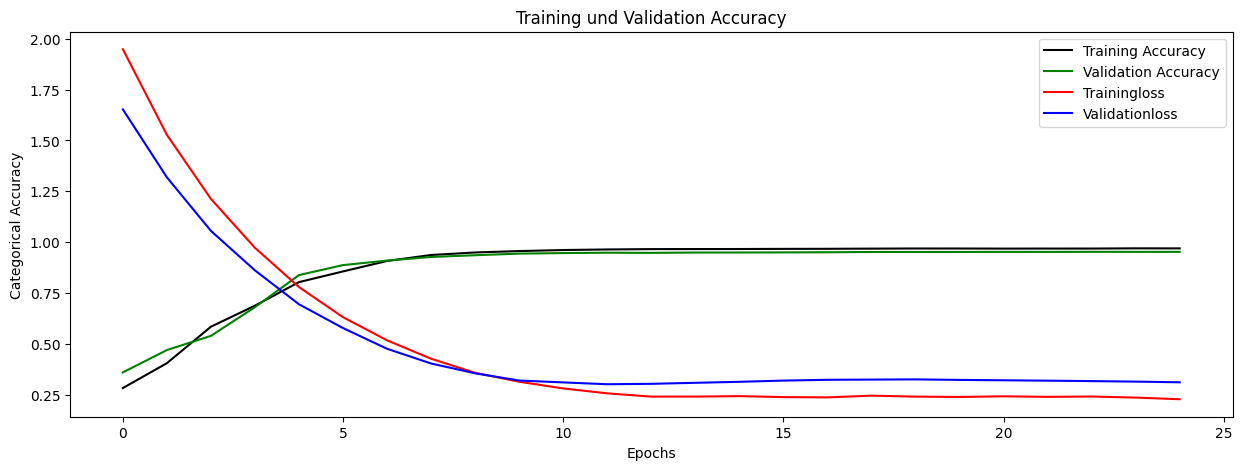

In [4]:
network_gen.print_training(results)

## Test Network and Generate Metrics

In [5]:
x_batch, y_batch = next(test_data_generator)
network_gen.test_predictions(network_gen.model, x_batch, y_batch, True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 45)             │           540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 45)             │         2,070 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           414 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,098 (47.26 KB)

 Trainable params: 3,024 (11.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,074 (35.45 KB)

17597/17597 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - categorical_accuracy: 0.9590 - loss: 0.2859
17597/17597 ━━━━━━━━━━━━━━━━━━━━ 10s 582us/step
Confusion Matrix
[[ 86771   1432    129     23      4      1      0      0      1]
 [  1413  72701   1489    142     17      3      3      0      0]
 [   105   1435  60193   1361    141     22      4      0      0]
 [    30    132   1307  51545   1164    122     20      7      6]
 [    13     24     99   1118  42802   1538    111     21     21]
 [     7     15     19    105   1079  33760   1918    111     32]
 [    10      9     16     22    112    968  28764    881    143]
 [     0      5      1      9     15     71    897  27309    975]
 [     9     14      9      9     14     25    112    884 137284]]
Klassifikations Report
0.9610110765198026
Akkuratheit der Klassifikation
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     88361
           1       0.96      0.96      0.96     75768
           2